# Time Series Clustering

## 0. 데이터 불러오기

In [3]:
!pip install tslearn

     |████████████████████████████████| 798kB 24.0MB/s 


In [1]:
import numpy as np
import pandas as pd
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
os.chdir('/content/drive/MyDrive/기상청/데이터')

In [8]:
data = pd.read_csv('data.csv', encoding='CP949')

In [14]:
data.head()

,date,sex,age,big_cat,sm_cat,qty,cnt
0,20180101,F,20,식품,가공란,37,0.480964
1,20180101,F,30,식품,가공란,16,0.480964
2,20180101,F,40,식품,가공란,9,0.480964
3,20180101,F,50,식품,가공란,3,0.480964
4,20180101,M,20,식품,가공란,13,0.480964


# 2. 데이터 전처리

## 2-1. 일별 평균

In [16]:
data.columns

Index(['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty', 'cnt'], dtype='object')

In [9]:
data['mmdd'] = data.date.progress_apply(lambda x: str(x)[4:])

In [10]:
df_mean = data.groupby(['mmdd','sm_cat'])['qty','cnt'].mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [28]:
df_mean.head()

,mmdd,sm_cat,qty,cnt
0,0101,가공란,20.705882,1.258775
1,0101,가열식 가습기,2.538462,3.275823
2,0101,가자미,2.687500,6.577482
3,0101,갈비/찜/바비큐용 돈육,3.461538,1.558357
4,0101,갈비용 우육,3.000000,0.000000


## 2-2. 데이터 재구조화

In [11]:
df_ts = df_mean.pivot(index='sm_cat', columns='mmdd', values='qty')

In [33]:
df_ts.head()

mmdd,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,0111,0112,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0125,0126,0127,0128,0129,0130,0131,0201,0202,0203,0204,0205,0206,0207,0208,0209,...,1122,1123,1124,1125,1126,1127,1128,1129,1130,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,20.705882,22.105263,17.263158,14.944444,16.000000,17.500000,22.611111,22.315789,25.842105,21.315789,17.850000,11.631579,18.210526,23.000000,20.736842,18.473684,41.500000,18.411765,10.947368,17.500000,19.555556,21.277778,16.600000,16.294118,20.736842,10.631579,12.882353,18.944444,16.578947,35.684211,14.823529,10.150000,9.400000,6.388889,15.066667,11.000000,10.684211,17.315789,15.050000,13.700000,...,14.000000,10.850000,13.600000,32.300000,26.000000,22.526316,18.450000,20.157895,31.000000,14.055556,27.050000,21.700000,18.450000,19.421053,14.473684,11.105263,12.210526,15.222222,25.150000,19.250000,19.894737,13.600000,10.631579,11.705882,17.947368,23.894737,18.666667,21.555556,17.200000,8.600000,11.000000,16.050000,17.050000,14.210526,37.200000,20.3500,25.000000,14.588235,16.473684,21.650000
가스온수기,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,1.000000,2.000000,1.000000,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.500000,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,1.500000,NaN,NaN,...,NaN,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,NaN,3.000000,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.500000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.0000,NaN,NaN,NaN,NaN
가열식 가습기,2.538462,3.125000,2.785714,2.333333,2.307692,2.333333,2.333333,3.000000,3.307692,1.937500,2.076923,1.909091,2.750000,1.800000,2.200000,1.727273,2.111111,1.400000,1.571429,1.555556,1.833333,1.700000,1.750000,2.125000,2.300000,2.111111,1.285714,2.100000,2.076923,2.777778,2.111111,1.222222,1.800000,1.400000,1.750000,1.666667,1.375000,1.750000,1.875000,1.857143,...,3.000000,2.071429,2.230769,3.266667,2.571429,2.941176,2.750000,3.636364,3.363636,2.200000,3.800000,3.882353,3.785714,4.000000,7.266667,3.615385,3.071429,4.294118,3.941176,4.400000,3.437500,3.000000,2.916667,3.071429,3.428571,2.846154,2.937500,3.125000,2.333333,2.916667,3.181818,3.076923,2.615385,2.083333,2.562500,2.7500,2.875000,2.444444,3.153846,2.384615
가자미,2.687500,3.642857,3.000000,4.153846,3.200000,2.750000,3.400000,5.411765,4.866667,6.071429,3.357143,3.500000,4.214286,3.875000,6.000000,4.625000,2.923077,2.812500,3.384615,5.714286,2.500000,7.578947,6.066667,2.600000,4.866667,4.411765,2.583333,4.578947,4.562500,3.076923,3.300000,3.153846,2.454545,2.416667,3.300000,4.000000,5.933333,4.133333,3.153846,2.928571,...,3.333333,2.888889,3.444444,3.294118,2.562500,3.666667,3.133333,3.846154,3.000000,3.076923,5.529412,4.000000,3.214286,5.055556,3.333333,2.333333,2.333333,3.235294,2.928571,3.500000,3.916667,5.444444,3.583333,2.647059,3.666667,3.437500,3.571429,4.125000,3.411765,3.333333,2.687500,3.133333,2.250000,3.571429,3.571429,3.6875,6.375000,3.000000,3.062500,5.000000
갈비/찜/바비큐용 돈육,3.461538,2.666667,1.636364,2.000000,2.000000,2.363636,2.400000,1.916667,2.785714,2.230769,2.333333,2.785714,3.250000,2.642857,2.571429,2.500000,3.214286,2.363636,2.100000,2.600000,1.727273,2.307692,2.333333,3.166667,3.000000,1.937500,2.727273,3.857143,2.153846,2.625000,2.384615,1.800000,2.454545,2.500000,3.000000,2.416667,2.333333,2.000000,3.333333,3.153846,...,3.000000,2.083333,2.937500,4.142857,2.666667,2.666667,2.538462,2.857143,3.363636,3.153846,2.500000,2.833333,4.411765,4.142857,2.357143,3.142857,2.857143,3.636364,2.000000,2.692308,3.066667,2.785714,3.428571,3.538462,2.866667,4.733333,3.928571,3.066667,3.066667,2.583333,4.214286,3.000000,3.125000,3.533333,3.333333,2.7000,3.538462,3.133333,3.666667,3.857143


## 2-3. 결측치

In [12]:
df_ts.fillna(0, inplace = True)

## 2-4. 데이터 정규화

In [13]:
avg_lst = []; std_lst = []
for idx, row in tqdm(df_ts.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())

In [14]:
df_ts['avg'] = avg_lst
df_ts['std'] = std_lst
df_ts.head()

mmdd,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,0111,0112,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0125,0126,0127,0128,0129,0130,0131,0201,0202,0203,0204,0205,0206,0207,0208,0209,...,1124,1125,1126,1127,1128,1129,1130,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,avg,std
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,20.705882,22.105263,17.263158,14.944444,16.000000,17.500000,22.611111,22.315789,25.842105,21.315789,17.850000,11.631579,18.210526,23.000000,20.736842,18.473684,41.500000,18.411765,10.947368,17.500000,19.555556,21.277778,16.600000,16.294118,20.736842,10.631579,12.882353,18.944444,16.578947,35.684211,14.823529,10.150000,9.400000,6.388889,15.066667,11.000000,10.684211,17.315789,15.050000,13.700000,...,13.600000,32.300000,26.000000,22.526316,18.450000,20.157895,31.000000,14.055556,27.050000,21.700000,18.450000,19.421053,14.473684,11.105263,12.210526,15.222222,25.150000,19.250000,19.894737,13.600000,10.631579,11.705882,17.947368,23.894737,18.666667,21.555556,17.200000,8.600000,11.000000,16.050000,17.050000,14.210526,37.200000,20.3500,25.000000,14.588235,16.473684,21.650000,19.174227,6.349053
가스온수기,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.500000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.500000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,0.346575,0.545733
가열식 가습기,2.538462,3.125000,2.785714,2.333333,2.307692,2.333333,2.333333,3.000000,3.307692,1.937500,2.076923,1.909091,2.750000,1.800000,2.200000,1.727273,2.111111,1.400000,1.571429,1.555556,1.833333,1.700000,1.750000,2.125000,2.300000,2.111111,1.285714,2.100000,2.076923,2.777778,2.111111,1.222222,1.800000,1.400000,1.750000,1.666667,1.375000,1.750000,1.875000,1.857143,...,2.230769,3.266667,2.571429,2.941176,2.750000,3.636364,3.363636,2.200000,3.800000,3.882353,3.785714,4.000000,7.266667,3.615385,3.071429,4.294118,3.941176,4.400000,3.437500,3.000000,2.916667,3.071429,3.428571,2.846154,2.937500,3.125000,2.333333,2.916667,3.181818,3.076923,2.615385,2.083333,2.562500,2.7500,2.875000,2.444444,3.153846,2.384615,1.600741,1.023066
가자미,2.687500,3.642857,3.000000,4.153846,3.200000,2.750000,3.400000,5.411765,4.866667,6.071429,3.357143,3.500000,4.214286,3.875000,6.000000,4.625000,2.923077,2.812500,3.384615,5.714286,2.500000,7.578947,6.066667,2.600000,4.866667,4.411765,2.583333,4.578947,4.562500,3.076923,3.300000,3.153846,2.454545,2.416667,3.300000,4.000000,5.933333,4.133333,3.153846,2.928571,...,3.444444,3.294118,2.562500,3.666667,3.133333,3.846154,3.000000,3.076923,5.529412,4.000000,3.214286,5.055556,3.333333,2.333333,2.333333,3.235294,2.928571,3.500000,3.916667,5.444444,3.583333,2.647059,3.666667,3.437500,3.571429,4.125000,3.411765,3.333333,2.687500,3.133333,2.250000,3.571429,3.571429,3.6875,6.375000,3.000000,3.062500,5.000000,3.583494,1.474306
갈비/찜/바비큐용 돈육,3.461538,2.666667,1.636364,2.000000,2.000000,2.363636,2.400000,1.916667,2.785714,2.230769,2.333333,2.785714,3.250000,2.642857,2.571429,2.500000,3.214286,2.363636,2.100000,2.600000,1.727273,2.307692,2.333333,3.166667,3.000000,1.937500,2.727273,3.857143,2.153846,2.625000,2.384615,1.800000,2.454545,2.500000,3.000000,2.416667,2.333333,2.000000,3.333333,3.153846,...,2.937500,4.142857,2.666667,2.666667,2.538462,2.857143,3.363636,3.153846,2.500000,2.833333,4.411765,4.142857,2.357143,3.142857,2.857143,3.63636

In [15]:
for i in tqdm(range(len(df_ts))):
    for j in range(365):
        df_ts.iloc[i,j] = (df_ts.iloc[i,j] - df_ts.iloc[i,365])/df_ts.iloc[i,366]

In [16]:
df_ts = df_ts.drop(['avg','std'], axis=1)

In [47]:
df_ts.head()

mmdd,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,0111,0112,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0125,0126,0127,0128,0129,0130,0131,0201,0202,0203,0204,0205,0206,0207,0208,0209,...,1123,1124,1125,1126,1127,1128,1129,1130,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,cluster
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,0.241241,0.461649,-0.301001,-0.666207,-0.499953,-0.263697,0.541322,0.494808,1.050216,0.337304,-0.208571,-1.187996,-0.151787,0.602574,0.246118,-0.110338,3.516394,-0.120091,-1.295762,-0.263697,0.060061,0.331317,-0.405451,-0.453628,0.246118,-1.345500,-0.990994,-0.036192,-0.408766,2.600385,-0.685252,-1.421350,-1.539478,-2.013740,-0.646956,-1.287472,-1.337210,-0.292711,-0.649582,-0.862212,...,-1.311098,-0.877962,2.067359,1.075085,0.527967,-0.114069,0.154931,1.862604,-0.806210,1.240464,0.397819,-0.114069,0.038876,-0.740353,-1.270893,-1.096809,-0.622456,0.941207,0.011934,0.113483,-0.877962,-1.345500,-1.176293,-0.193235,0.743498,-0.079943,0.375068,-0.310948,-1.665481,-1.287472,-0.492078,-0.334574,-0.781802,2.839128,0.185189,0.917581,-0.722311,-0.425346,0.389944,2
가스온수기,-0.635064,1.197333,-0.635064,-0.635064,-0.635064,-0.635064,1.197333,-0.635064,1.197333,1.197333,-0.635064,-0.635064,1.197333,3.029730,1.197333,1.197333,1.197333,-0.635064,1.197333,-0.635064,-0.635064,-0.635064,-0.635064,-0.635064,-0.635064,-0.635064,-0.635064,-0.635064,2.113532,-0.635064,-0.635064,1.197333,1.197333,-0.635064,-0.635064,-0.635064,1.197333,2.113532,-0.635064,-0.635064,...,1.197333,1.197333,1.197333,-0.635064,1.197333,1.197333,-0.635064,4.862128,-0.635064,1.197333,1.197333,-0.635064,-0.635064,1.197333,1.197333,-0.635064,1.197333,-0.635064,-0.635064,-0.635064,1.197333,1.197333,-0.635064,-0.635064,2.113532,1.197333,1.197333,1.197333,1.197333,-0.635064,-0.635064,-0.635064,-0.635064,-0.635064,1.197333,-0.635064,-0.635064,-0.635064,-0.635064,0
가열식 가습기,0.916579,1.489893,1.158257,0.716076,0.691013,0.716076,0.716076,1.367712,1.668467,0.329167,0.465446,0.301398,1.123348,0.194767,0.585748,0.123679,0.498863,-0.196215,-0.028651,-0.044167,0.227348,0.097021,0.145894,0.512439,0.683494,0.498863,-0.307924,0.488003,0.465446,1.150500,0.498863,-0.369985,0.194767,-0.196215,0.145894,0.064439,-0.220651,0.145894,0.268076,0.250621,...,0.460076,0.615824,1.628366,0.948803,1.310214,1.123348,1.989728,1.723149,0.585748,2.149675,2.230171,2.135711,2.345166,5.538183,1.969222,1.437530,2.632652,2.287668,2.736147,1.795348,1.367712,1.286257,1.437530,1.786621,1.217334,1.306621,1.489893,0.716076,1.286257,1.545431,1.442900,0.991768,0.471712,0.940075,1.123348,1.245530,0.824682,1.518089,0.766201,3
가자미,-0.607739,0.040265,-0.395775,0.386862,-0.260118,-0.565346,-0.124461,1.240089,0.870357,1.687529,-0.153530,-0.056632,0.427857,0.197724,1.639081,0.706438,-0.447951,-0.522954,-0.134896,1.445285,-0.734918,2.710057,1.684300,-0.667089,0.870357,0.561804,-0.678394,0.675202,0.664046,-0.343599,-0.192290,-0.291424,-0.765749,-0.791441,-0.192290,0.282510,1.593862,0.372948,-0.291424,-0.444224,...,-0.471140,-0.094315,-0.196279,-0.692525,0.056415,-0.305337,0.178159,-0.395775,-0.343599,1.319887,0.282510,-0.250428,0.998478,-0.169680,-0.847965,-0.847965,-0.236179,-0.444224,-0.056632,0.225986,1.262255,-0.000109,-0.635170,0.056415,-0.099025,-0.008184,0.367296,-0.116481,-0.169680,-0.607739,-0.305337,-0.904489,-0.008184,-0.008184,0.070546,1.893437,-0.395775,-0.353382,0.960795,2
갈비/찜/바비큐용 돈육,0.822663,-0.229296,-1.592831,-1.111583,-1.111583,-0.630335,-0.582211,-1.221869,-0.071744,-0.806176,-0.670439,-0.071744,0.542706,-0.260806,-0.355337,-0.449868,0.495441,-0.630335,-0.979240,-0.317524,-1.472519,-0.704374,-0.670439,0.432420,0.211848,-1.194298,-0.149088,1.346218,-0.907978,-0.284439,-0.602571,-1.376270,-0.510024,-0.449868,0.211848,-0.560153,-0.670439,-1.111583,0.652992,0.415453,...,-1.001297,0.129134,1.724342,-0.229296,-0.229296,-0.39

# 3. Time Series Clustering

* Euclidean

### 3-1. 최적의 k

In [80]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in range(1, 15):
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'euclidean')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)

    plt.plot(range(1, 15), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

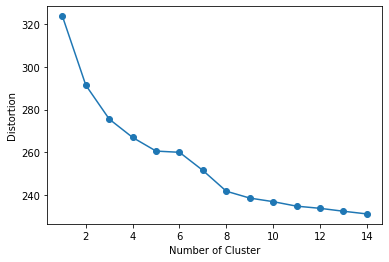

In [81]:
visualize_elbowmethod(df_ts)

* elbow point = 5

In [82]:
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,15)
    results = []

    for i in clusters_range:
        clusterer = TimeSeriesKMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=1234, metric = 'euclidean')
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

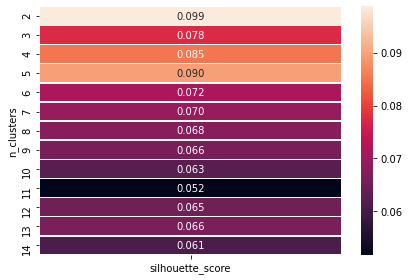

In [83]:
visualize_silhouette_layer(df_ts)

* silhouette score: 점수가 가장 높은 값은 2지만, 클러스터 수가 너무 적고 elbow point도 고려하여 최적의 k 5 선택

### 3-2. Clustering

In [17]:
%%time
model = TimeSeriesKMeans(n_clusters=5, init='random', n_init=10, max_iter=300, random_state=1234, metric = 'euclidean').fit(df_ts)

CPU times: user 2.51 s, sys: 29.6 ms, total: 2.54 s
Wall time: 2.54 s


In [18]:
result = model.predict(df_ts)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 383 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [19]:
df_ts['cluster'] = result

In [87]:
df_ts.head()

mmdd,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,0111,0112,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0125,0126,0127,0128,0129,0130,0131,0201,0202,0203,0204,0205,0206,0207,0208,0209,...,1123,1124,1125,1126,1127,1128,1129,1130,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,cluster
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,0.246051,0.465838,-0.294665,-0.658843,-0.493057,-0.257466,0.545287,0.498904,1.052748,0.341843,-0.202495,-1.179163,-0.145871,0.606366,0.250914,-0.104539,3.511984,-0.114264,-1.286625,-0.257466,0.065380,0.335873,-0.398821,-0.446863,0.250914,-1.336223,-0.982716,-0.030601,-0.402127,2.598554,-0.677834,-1.411860,-1.529656,-2.002582,-0.639647,-1.278359,-1.327957,-0.286398,-0.642264,-0.854296,...,-1.301918,-0.870002,2.067028,1.077547,0.531969,-0.108259,0.159984,1.862850,-0.798452,1.242461,0.402188,-0.108259,0.044255,-0.732781,-1.261826,-1.088233,-0.615215,0.944046,0.017390,0.118652,-0.870002,-1.336223,-1.167493,-0.187202,0.746894,-0.074229,0.379501,-0.304584,-1.655304,-1.278359,-0.485204,-0.328143,-0.774112,2.836624,0.190156,0.920487,-0.714789,-0.418660,0.394335,1
가스온수기,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,1.193714,-0.638804,1.193714,1.193714,-0.638804,-0.638804,1.193714,3.026231,1.193714,1.193714,1.193714,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,2.109973,-0.638804,-0.638804,1.193714,1.193714,-0.638804,-0.638804,-0.638804,1.193714,2.109973,-0.638804,-0.638804,...,1.193714,1.193714,1.193714,-0.638804,1.193714,1.193714,-0.638804,4.858749,-0.638804,1.193714,1.193714,-0.638804,-0.638804,1.193714,1.193714,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,1.193714,1.193714,-0.638804,-0.638804,2.109973,1.193714,1.193714,1.193714,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,3
가열식 가습기,0.919781,1.494270,1.161954,0.718867,0.693753,0.718867,0.718867,1.371838,1.673209,0.331166,0.467724,0.303340,1.126974,0.196490,0.588273,0.125257,0.501210,-0.195292,-0.027385,-0.042932,0.229139,0.098545,0.147518,0.514814,0.686218,0.501210,-0.307230,0.490327,0.467724,1.154181,0.501210,-0.369417,0.196490,-0.195292,0.147518,0.065896,-0.219778,0.147518,0.269950,0.252459,...,0.462343,0.618410,1.633026,0.952071,1.314223,1.126974,1.995128,1.728004,0.588273,2.155403,2.236064,2.141410,2.351294,5.550850,1.974580,1.441799,2.639369,2.293679,2.743076,1.800350,1.371838,1.290216,1.441799,1.791605,1.221152,1.310622,1.494270,0.718867,1.290216,1.549921,1.447181,0.995124,0.474003,0.943326,1.126974,1.249406,0.827695,1.522523,0.769096,4
가자미,-0.603807,0.044161,-0.391855,0.390738,-0.256205,-0.561417,-0.120556,1.243918,0.874206,1.691333,-0.149624,-0.052731,0.431731,0.201611,1.642886,0.710297,-0.444028,-0.519026,-0.130991,1.449102,-0.730978,2.713803,1.688103,-0.663154,0.874206,0.565670,-0.674458,0.679062,0.667906,-0.339682,-0.188381,-0.287509,-0.761808,-0.787499,-0.188381,0.286392,1.597670,0.376825,-0.287509,-0.440301,...,-0.467216,-0.090412,-0.192370,-0.688588,0.060310,-0.301422,0.182046,-0.391855,-0.339682,1.323711,0.286392,-0.246516,1.002320,-0.165773,-0.844020,-0.844020,-0.232267,-0.440301,-0.052731,0.229872,1.266082,0.003789,-0.631236,0.060310,-0.095122,-0.004285,0.371173,-0.112577,-0.165773,-0.603807,-0.301422,-0.900540,-0.004285,-0.004285,0.074440,1.897229,-0.391855,-0.349464,0.964639,1
갈비/찜/바비큐용 돈육,0.823913,-0.220105,-1.573349,-1.095734,-1.095734,-0.618118,-0.570357,-1.205187,-0.063743,-0.792632,-0.657920,-0.063743,0.546069,-0.251378,-0.345195,-0.439012,0.499161,-0.618118,-0.964389,-0.307668,-1.453945,-0.691598,-0.657920,0.436616,0.217709,-1.177824,-0.140503,1.343517,-0.893666,-0.274832,-0.590564,-1.358422,-0.498714,-0.439012,0.217709,-0.548466,-0.657920,-1.095734,0.655523,0.419777,...,-0.986280,0.135619,1.718786,-0.220105,-0.220105,-0.388

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

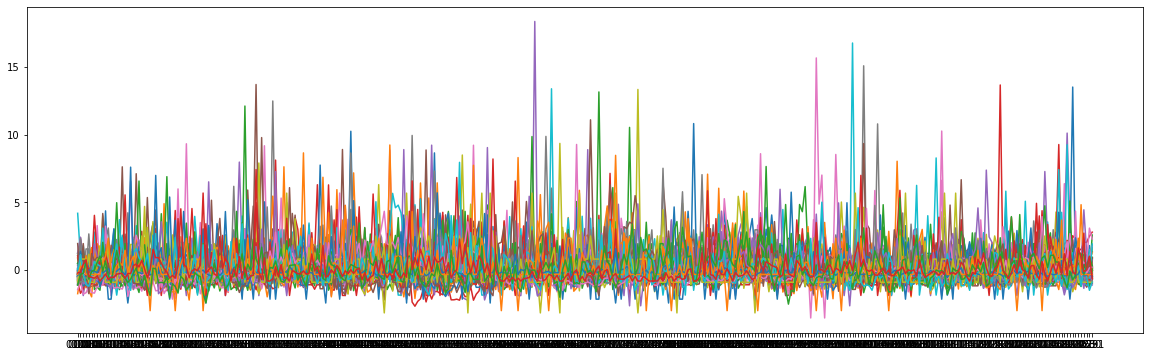

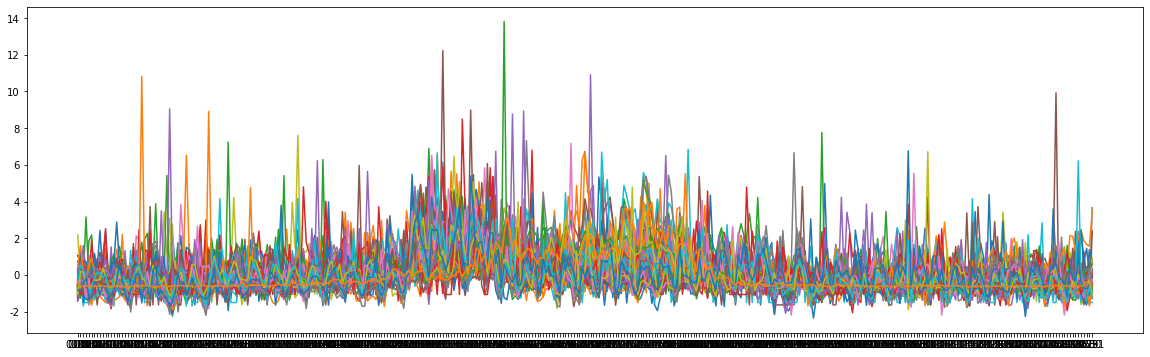

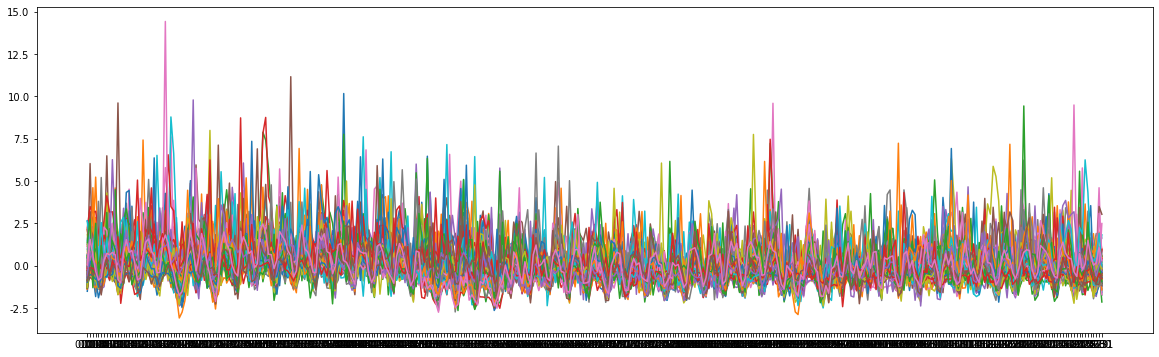

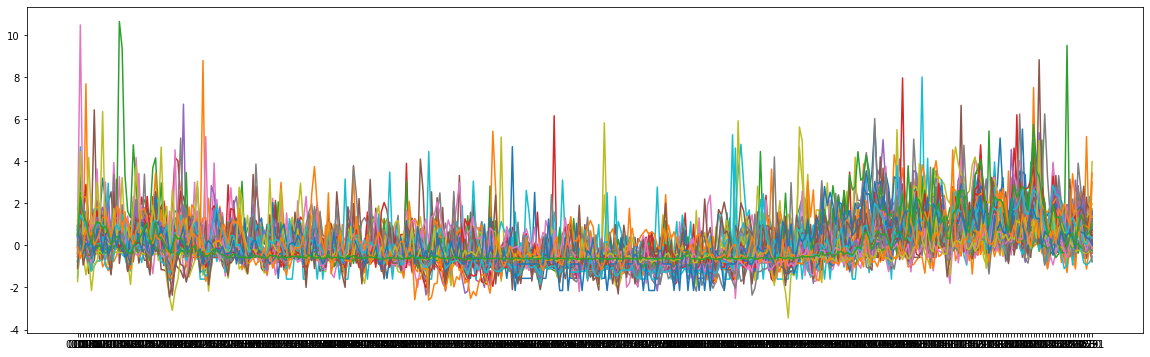

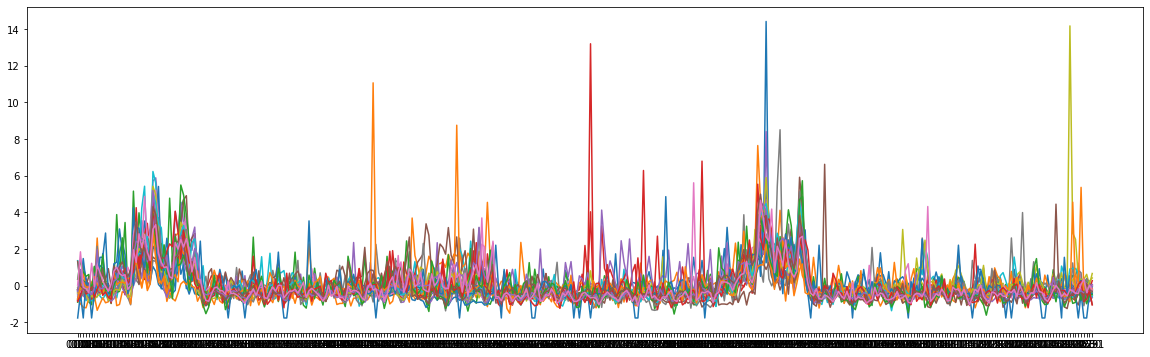

In [66]:
for i in range(5):
    clusters = df_ts[df_ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

<function matplotlib.pyplot.show>

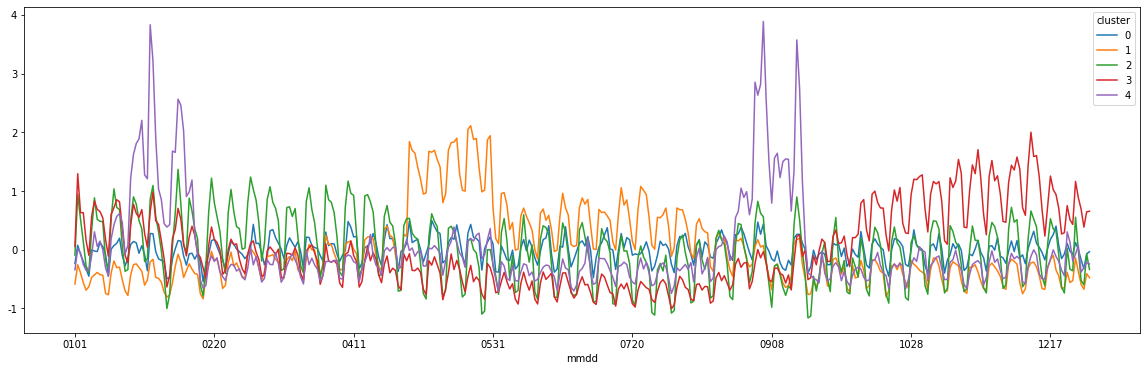

In [48]:
plt.rcParams["figure.figsize"]=(20,6)
df_ts.reset_index().groupby(['cluster']).mean().T.plot()
plt.show

In [91]:
df_ts.drop(['cluster'],axis=1,inplace=True)

* DTW

### 3-1. 최적의 k

In [96]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 15)):
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)

    plt.plot(range(2, 15), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

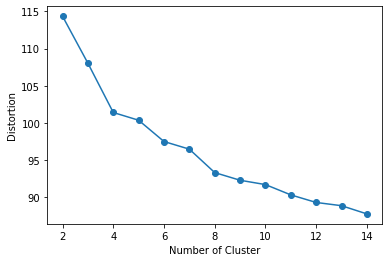

In [97]:
# 약 2시간 소요
visualize_elbowmethod(df_ts)

* elbow point = 4

In [100]:
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,7)
    results = []

    for i in tqdm(clusters_range):
        clusterer = TimeSeriesKMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

In [101]:
# 55분째 k 하나도 안돌아감..
visualize_silhouette_layer(df_ts)

KeyboardInterrupt: ignored

* silhouette score = 5

### 3-2. Clustering

In [102]:
# 1시간 30분
%%time
model_dtw = TimeSeriesKMeans(n_clusters=4, init='random', n_init=10, max_iter=300, random_state=1234, metric = 'dtw').fit(df_ts)

CPU times: user 1h 18min 40s, sys: 14min 19s, total: 1h 33min
Wall time: 1h 20min 25s


In [103]:
result_dtw = model_dtw.predict(df_ts)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 383 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [104]:
df_ts['cluster'] = result_dtw

In [105]:
df_ts.head()

mmdd,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,0111,0112,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0125,0126,0127,0128,0129,0130,0131,0201,0202,0203,0204,0205,0206,0207,0208,0209,...,1123,1124,1125,1126,1127,1128,1129,1130,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,cluster
sm_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
가공란,0.246051,0.465838,-0.294665,-0.658843,-0.493057,-0.257466,0.545287,0.498904,1.052748,0.341843,-0.202495,-1.179163,-0.145871,0.606366,0.250914,-0.104539,3.511984,-0.114264,-1.286625,-0.257466,0.065380,0.335873,-0.398821,-0.446863,0.250914,-1.336223,-0.982716,-0.030601,-0.402127,2.598554,-0.677834,-1.411860,-1.529656,-2.002582,-0.639647,-1.278359,-1.327957,-0.286398,-0.642264,-0.854296,...,-1.301918,-0.870002,2.067028,1.077547,0.531969,-0.108259,0.159984,1.862850,-0.798452,1.242461,0.402188,-0.108259,0.044255,-0.732781,-1.261826,-1.088233,-0.615215,0.944046,0.017390,0.118652,-0.870002,-1.336223,-1.167493,-0.187202,0.746894,-0.074229,0.379501,-0.304584,-1.655304,-1.278359,-0.485204,-0.328143,-0.774112,2.836624,0.190156,0.920487,-0.714789,-0.418660,0.394335,3
가스온수기,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,1.193714,-0.638804,1.193714,1.193714,-0.638804,-0.638804,1.193714,3.026231,1.193714,1.193714,1.193714,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,2.109973,-0.638804,-0.638804,1.193714,1.193714,-0.638804,-0.638804,-0.638804,1.193714,2.109973,-0.638804,-0.638804,...,1.193714,1.193714,1.193714,-0.638804,1.193714,1.193714,-0.638804,4.858749,-0.638804,1.193714,1.193714,-0.638804,-0.638804,1.193714,1.193714,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,1.193714,1.193714,-0.638804,-0.638804,2.109973,1.193714,1.193714,1.193714,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,3
가열식 가습기,0.919781,1.494270,1.161954,0.718867,0.693753,0.718867,0.718867,1.371838,1.673209,0.331166,0.467724,0.303340,1.126974,0.196490,0.588273,0.125257,0.501210,-0.195292,-0.027385,-0.042932,0.229139,0.098545,0.147518,0.514814,0.686218,0.501210,-0.307230,0.490327,0.467724,1.154181,0.501210,-0.369417,0.196490,-0.195292,0.147518,0.065896,-0.219778,0.147518,0.269950,0.252459,...,0.462343,0.618410,1.633026,0.952071,1.314223,1.126974,1.995128,1.728004,0.588273,2.155403,2.236064,2.141410,2.351294,5.550850,1.974580,1.441799,2.639369,2.293679,2.743076,1.800350,1.371838,1.290216,1.441799,1.791605,1.221152,1.310622,1.494270,0.718867,1.290216,1.549921,1.447181,0.995124,0.474003,0.943326,1.126974,1.249406,0.827695,1.522523,0.769096,0
가자미,-0.603807,0.044161,-0.391855,0.390738,-0.256205,-0.561417,-0.120556,1.243918,0.874206,1.691333,-0.149624,-0.052731,0.431731,0.201611,1.642886,0.710297,-0.444028,-0.519026,-0.130991,1.449102,-0.730978,2.713803,1.688103,-0.663154,0.874206,0.565670,-0.674458,0.679062,0.667906,-0.339682,-0.188381,-0.287509,-0.761808,-0.787499,-0.188381,0.286392,1.597670,0.376825,-0.287509,-0.440301,...,-0.467216,-0.090412,-0.192370,-0.688588,0.060310,-0.301422,0.182046,-0.391855,-0.339682,1.323711,0.286392,-0.246516,1.002320,-0.165773,-0.844020,-0.844020,-0.232267,-0.440301,-0.052731,0.229872,1.266082,0.003789,-0.631236,0.060310,-0.095122,-0.004285,0.371173,-0.112577,-0.165773,-0.603807,-0.301422,-0.900540,-0.004285,-0.004285,0.074440,1.897229,-0.391855,-0.349464,0.964639,3
갈비/찜/바비큐용 돈육,0.823913,-0.220105,-1.573349,-1.095734,-1.095734,-0.618118,-0.570357,-1.205187,-0.063743,-0.792632,-0.657920,-0.063743,0.546069,-0.251378,-0.345195,-0.439012,0.499161,-0.618118,-0.964389,-0.307668,-1.453945,-0.691598,-0.657920,0.436616,0.217709,-1.177824,-0.140503,1.343517,-0.893666,-0.274832,-0.590564,-1.358422,-0.498714,-0.439012,0.217709,-0.548466,-0.657920,-1.095734,0.655523,0.419777,...,-0.986280,0.135619,1.718786,-0.220105,-0.220105,-0.388

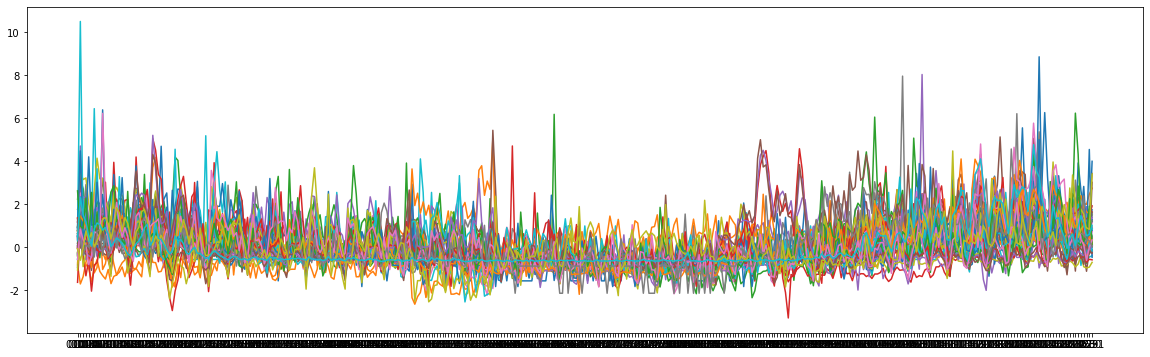

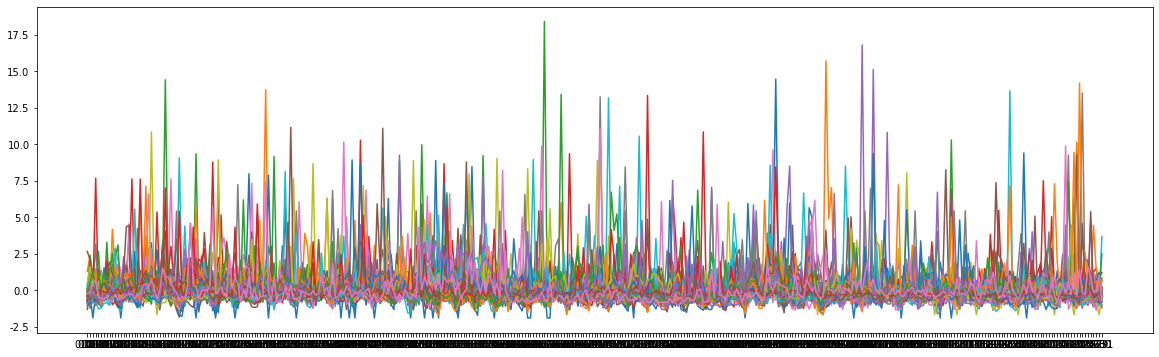

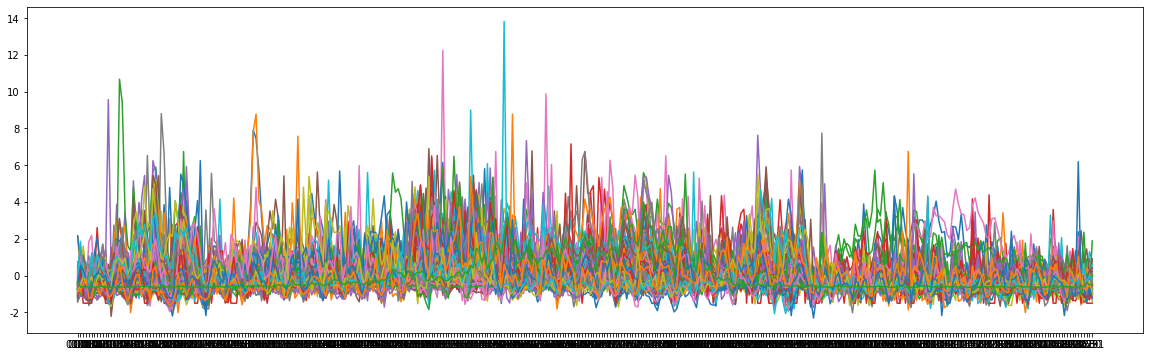

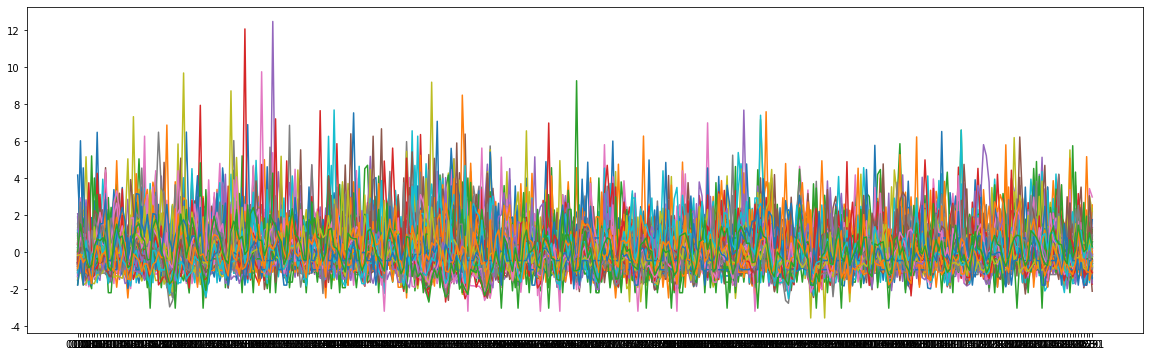

In [72]:
for i in range(4):
    clusters = df_dtw.set_index('sm_cat')[df_dtw.set_index('sm_cat')['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

In [114]:
df = df_ts.reset_index()

In [115]:
df.head()

mmdd,sm_cat,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,0111,0112,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0125,0126,0127,0128,0129,0130,0131,0201,0202,0203,0204,0205,0206,0207,0208,...,1123,1124,1125,1126,1127,1128,1129,1130,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,cluster
0,가공란,0.246051,0.465838,-0.294665,-0.658843,-0.493057,-0.257466,0.545287,0.498904,1.052748,0.341843,-0.202495,-1.179163,-0.145871,0.606366,0.250914,-0.104539,3.511984,-0.114264,-1.286625,-0.257466,0.065380,0.335873,-0.398821,-0.446863,0.250914,-1.336223,-0.982716,-0.030601,-0.402127,2.598554,-0.677834,-1.411860,-1.529656,-2.002582,-0.639647,-1.278359,-1.327957,-0.286398,-0.642264,...,-1.301918,-0.870002,2.067028,1.077547,0.531969,-0.108259,0.159984,1.862850,-0.798452,1.242461,0.402188,-0.108259,0.044255,-0.732781,-1.261826,-1.088233,-0.615215,0.944046,0.017390,0.118652,-0.870002,-1.336223,-1.167493,-0.187202,0.746894,-0.074229,0.379501,-0.304584,-1.655304,-1.278359,-0.485204,-0.328143,-0.774112,2.836624,0.190156,0.920487,-0.714789,-0.418660,0.394335,3
1,가스온수기,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,1.193714,-0.638804,1.193714,1.193714,-0.638804,-0.638804,1.193714,3.026231,1.193714,1.193714,1.193714,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,2.109973,-0.638804,-0.638804,1.193714,1.193714,-0.638804,-0.638804,-0.638804,1.193714,2.109973,-0.638804,...,1.193714,1.193714,1.193714,-0.638804,1.193714,1.193714,-0.638804,4.858749,-0.638804,1.193714,1.193714,-0.638804,-0.638804,1.193714,1.193714,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,1.193714,1.193714,-0.638804,-0.638804,2.109973,1.193714,1.193714,1.193714,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,3
2,가열식 가습기,0.919781,1.494270,1.161954,0.718867,0.693753,0.718867,0.718867,1.371838,1.673209,0.331166,0.467724,0.303340,1.126974,0.196490,0.588273,0.125257,0.501210,-0.195292,-0.027385,-0.042932,0.229139,0.098545,0.147518,0.514814,0.686218,0.501210,-0.307230,0.490327,0.467724,1.154181,0.501210,-0.369417,0.196490,-0.195292,0.147518,0.065896,-0.219778,0.147518,0.269950,...,0.462343,0.618410,1.633026,0.952071,1.314223,1.126974,1.995128,1.728004,0.588273,2.155403,2.236064,2.141410,2.351294,5.550850,1.974580,1.441799,2.639369,2.293679,2.743076,1.800350,1.371838,1.290216,1.441799,1.791605,1.221152,1.310622,1.494270,0.718867,1.290216,1.549921,1.447181,0.995124,0.474003,0.943326,1.126974,1.249406,0.827695,1.522523,0.769096,0
3,가자미,-0.603807,0.044161,-0.391855,0.390738,-0.256205,-0.561417,-0.120556,1.243918,0.874206,1.691333,-0.149624,-0.052731,0.431731,0.201611,1.642886,0.710297,-0.444028,-0.519026,-0.130991,1.449102,-0.730978,2.713803,1.688103,-0.663154,0.874206,0.565670,-0.674458,0.679062,0.667906,-0.339682,-0.188381,-0.287509,-0.761808,-0.787499,-0.188381,0.286392,1.597670,0.376825,-0.287509,...,-0.467216,-0.090412,-0.192370,-0.688588,0.060310,-0.301422,0.182046,-0.391855,-0.339682,1.323711,0.286392,-0.246516,1.002320,-0.165773,-0.844020,-0.844020,-0.232267,-0.440301,-0.052731,0.229872,1.266082,0.003789,-0.631236,0.060310,-0.095122,-0.004285,0.371173,-0.112577,-0.165773,-0.603807,-0.301422,-0.900540,-0.004285,-0.004285,0.074440,1.897229,-0.391855,-0.349464,0.964639,3
4,갈비/찜/바비큐용 돈육,0.823913,-0.220105,-1.573349,-1.095734,-1.095734,-0.618118,-0.570357,-1.205187,-0.063743,-0.792632,-0.657920,-0.063743,0.546069,-0.251378,-0.345195,-0.439012,0.499161,-0.618118,-0.964389,-0.307668,-1.453945,-0.691598,-0.657920,0.436616,0.217709,-1.177824,-0.140503,1.343517,-0.893666,-0.274832,-0.590564,-1.358422,-0.498714,-0.439012,0.217709,-0.548466,-0.657920,-1.095734,0.655523,...,-0.986280,0.135619,1.718786,-0.220105,-0.220105,-0.388495,0.030074,0.695324,0.419777,-0.439012,-0.001198,2.071980,1.718786,-0.626647,0.405343,0.030074,1.053536,-1.095734,-0.18642

In [121]:
df.to_csv('/content/drive/MyDrive/기상청/데이터/cluster_dtw.csv', encoding='CP949', index = False)

In [37]:
df_dtw = pd.read_csv('/content/drive/MyDrive/기상청/데이터/cluster_dtw.csv', encoding='CP949')

In [40]:
df_dtw.head()

,sm_cat,0101,0102,0103,0104,0105,0106,0107,0108,0109,0110,0111,0112,0113,0114,0115,0116,0117,0118,0119,0120,0121,0122,0123,0124,0125,0126,0127,0128,0129,0130,0131,0201,0202,0203,0204,0205,0206,0207,0208,...,1123,1124,1125,1126,1127,1128,1129,1130,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,cluster
0,가공란,0.246051,0.465838,-0.294665,-0.658843,-0.493057,-0.257466,0.545287,0.498904,1.052748,0.341843,-0.202495,-1.179163,-0.145871,0.606366,0.250914,-0.104539,3.511984,-0.114264,-1.286625,-0.257466,0.065380,0.335873,-0.398821,-0.446863,0.250914,-1.336223,-0.982716,-0.030601,-0.402127,2.598554,-0.677834,-1.411860,-1.529656,-2.002582,-0.639647,-1.278359,-1.327957,-0.286398,-0.642264,...,-1.301918,-0.870002,2.067028,1.077547,0.531969,-0.108259,0.159984,1.862850,-0.798452,1.242461,0.402188,-0.108259,0.044255,-0.732781,-1.261826,-1.088233,-0.615215,0.944046,0.017390,0.118652,-0.870002,-1.336223,-1.167493,-0.187202,0.746894,-0.074229,0.379501,-0.304584,-1.655304,-1.278359,-0.485204,-0.328143,-0.774112,2.836624,0.190156,0.920487,-0.714789,-0.418660,0.394335,3
1,가스온수기,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,1.193714,-0.638804,1.193714,1.193714,-0.638804,-0.638804,1.193714,3.026231,1.193714,1.193714,1.193714,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,2.109973,-0.638804,-0.638804,1.193714,1.193714,-0.638804,-0.638804,-0.638804,1.193714,2.109973,-0.638804,...,1.193714,1.193714,1.193714,-0.638804,1.193714,1.193714,-0.638804,4.858749,-0.638804,1.193714,1.193714,-0.638804,-0.638804,1.193714,1.193714,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,1.193714,1.193714,-0.638804,-0.638804,2.109973,1.193714,1.193714,1.193714,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,-0.638804,1.193714,-0.638804,-0.638804,-0.638804,-0.638804,3
2,가열식 가습기,0.919781,1.494270,1.161954,0.718867,0.693753,0.718867,0.718867,1.371838,1.673209,0.331166,0.467724,0.303340,1.126974,0.196490,0.588273,0.125257,0.501210,-0.195292,-0.027385,-0.042932,0.229139,0.098545,0.147518,0.514814,0.686218,0.501210,-0.307230,0.490327,0.467724,1.154181,0.501210,-0.369417,0.196490,-0.195292,0.147518,0.065896,-0.219778,0.147518,0.269950,...,0.462343,0.618410,1.633026,0.952071,1.314223,1.126974,1.995128,1.728004,0.588273,2.155403,2.236064,2.141410,2.351294,5.550850,1.974580,1.441799,2.639369,2.293679,2.743076,1.800350,1.371838,1.290216,1.441799,1.791605,1.221152,1.310622,1.494270,0.718867,1.290216,1.549921,1.447181,0.995124,0.474003,0.943326,1.126974,1.249406,0.827695,1.522523,0.769096,0
3,가자미,-0.603807,0.044161,-0.391855,0.390738,-0.256205,-0.561417,-0.120556,1.243918,0.874206,1.691333,-0.149624,-0.052731,0.431731,0.201611,1.642886,0.710297,-0.444028,-0.519026,-0.130991,1.449102,-0.730978,2.713803,1.688103,-0.663154,0.874206,0.565670,-0.674458,0.679062,0.667906,-0.339682,-0.188381,-0.287509,-0.761808,-0.787499,-0.188381,0.286392,1.597670,0.376825,-0.287509,...,-0.467216,-0.090412,-0.192370,-0.688588,0.060310,-0.301422,0.182046,-0.391855,-0.339682,1.323711,0.286392,-0.246516,1.002320,-0.165773,-0.844020,-0.844020,-0.232267,-0.440301,-0.052731,0.229872,1.266082,0.003789,-0.631236,0.060310,-0.095122,-0.004285,0.371173,-0.112577,-0.165773,-0.603807,-0.301422,-0.900540,-0.004285,-0.004285,0.074440,1.897229,-0.391855,-0.349464,0.964639,3
4,갈비/찜/바비큐용 돈육,0.823913,-0.220105,-1.573349,-1.095734,-1.095734,-0.618118,-0.570357,-1.205187,-0.063743,-0.792632,-0.657920,-0.063743,0.546069,-0.251378,-0.345195,-0.439012,0.499161,-0.618118,-0.964389,-0.307668,-1.453945,-0.691598,-0.657920,0.436616,0.217709,-1.177824,-0.140503,1.343517,-0.893666,-0.274832,-0.590564,-1.358422,-0.498714,-0.439012,0.217709,-0.548466,-0.657920,-1.095734,0.655523,...,-0.986280,0.135619,1.718786,-0.220105,-0.220105,-0.388495,0.030074,0.695324,0.419777,-0.439012,-0.001198,2.071980,1.718786,-0.626647,0.405343,0.030074,1.053536,-1.095734,-0.186427,0.

<function matplotlib.pyplot.show>

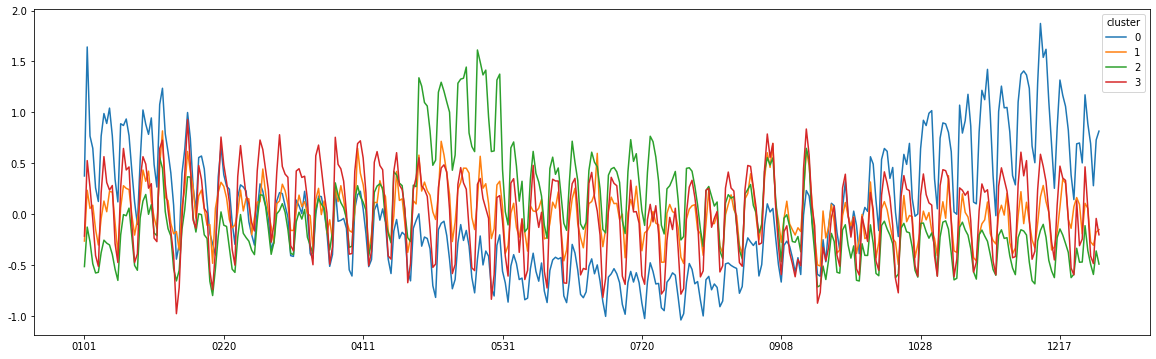

In [55]:
plt.rcParams["figure.figsize"]=(20,6)
df_dtw.groupby(['cluster']).mean().T.plot()
plt.show

In [58]:
pd.set_option('display.max_rows', 500)

In [64]:
print(df_dtw[df_dtw["cluster"]==0]["sm_cat"].shape)
df_dtw[df_dtw["cluster"]==0]["sm_cat"]

(50,)


2            가열식 가습기
8         감귤/한라봉/오렌지
10              감말랭이
31             견과류 밤
40               곡물차
51              굴 생물
61         기초 화장용 로션
65      기초 화장용 오일/앰플
66         기초 화장용 크림
74           난방용 열풍기
99            대게/킹크랩
104            돼지 곱창
106             둥굴레차
107      딸기/복분자/블루베리
108             딸기우유
109            라디에이터
133           바디 보습제
165          복합식 가습기
189       색조 메이크업 립밤
190      색조 메이크업 립스틱
199    색조 메이크업 아이섀도우
214           소고기 육회
230              시금치
234              쌈채소
249             에어워셔
264             온열매트
265              온풍기
271              유자차
272           유제품 음료
273              율무차
281          자연식 가습기
287            전기온수기
288             전기장판
295               조개
303         초음파식 가습기
307            카페트매트
312              컨벡터
313          코코아/핫초코
315           콩나물/숙주
337              풋크림
347             해초류 
349             핸드크림
358       헤어스타일링용 흑채
365             혼합견과
370         홍삼/인삼 제품
371          홍삼액/홍삼정
374               홍차
378          

In [62]:
print(df_dtw[df_dtw["cluster"]==1]["sm_cat"].shape)
df_dtw[df_dtw["cluster"]==1]["sm_cat"]

(67,)


6                     갈치
12                   갓김치
16                   건망고
17                  건바나나
19               건어물 노가리
23               건어물 진미채
28                   견과류
32              견과류 잣/은행
34               견과류 캐슈넛
35             견과류 피스타치오
49             구이/수육용 돈육
54          기능성 링클케어 화장품
55          기능성 모공관리 화장품
60            기능성 화장품 세트
69             기타 한방/환제품
71                    꽃게
82                 남성 크림
88                 네일리무버
90                  네일아트
100                 더치커피
102               도라지/더덕
110                  랍스타
118              메이크업 박스
121                명태/동태
124                   문어
134                바디 세트
138            바디케어용 때비누
139          바디케어용 볼륨업크림
140            바디케어용 슬리밍
144                  반찬류
148          베이스 메이크업 세트
150       베이스 메이크업용 CC크림
152    베이스 메이크업용 메이크업베이스
153        베이스 메이크업용 컨실러
155      베이스 메이크업용 트윈케이크
169               뷰티 손거울
171               뷰티 헤어캡
175           뷰티용 면봉/귀이개
176               뷰티용 뷰러
178           뷰티용 여드름압출기


In [63]:
print(df_dtw[df_dtw["cluster"]==2]["sm_cat"].shape)
df_dtw[df_dtw["cluster"]==2]["sm_cat"]

(113,)


7                 감/홍시
11                  감자
15                 건대추
21              건어물 멸치
24              건어물 황태
25                 건자두
26                 건포도
33           견과류 카카오닙스
37                  계란
39          고추/피망/파프리카
41             공기정화 용품
42               공기청정기
43              곶감/반건시
45                 과일류
46                과일세트
52               굴비/조기
68              기타 주스류
70                 김치류
76             남성 메이크업
77              남성 선케어
78               남성 세트
83              남성 클렌징
85                 냉풍기
86          네일 메이크업 용품
87             네일관리 소품
89                네일세트
91                네일컬러
96        다이어트용 헬스보충식품
101              데오드란트
111              레몬/자몽
116              마늘/생강
117            멀티형 에어컨
122               무/배추
123                무김치
125                물김치
126                미나리
127          미숫가루/곡물가루
130            밀크티/티라떼
131        바나나/파인애플/망고
132              바나나우유
136             바디 클렌져
137          바디케어용 땀패드
141          바디케어용 제모제
146        

In [65]:
print(df_dtw[df_dtw["cluster"]==3]["sm_cat"].shape)
df_dtw[df_dtw["cluster"]==3]["sm_cat"]

(153,)


0                   가공란
1                 가스온수기
3                   가자미
4          갈비/찜/바비큐용 돈육
5                갈비용 우육
9            감마리놀렌산 영양제
13                  건강즙
14               건강즙/녹용
18              건어물 건새우
20            건어물 마른오징어
22               건어물 쥐포
27                  게장류
29               견과류 땅콩
30            견과류 마카다미아
36               견과류 호두
38                  고등어
44                  과실차
47           과일채소 분말/분태
48             과채 음료/주스
50               국내산 돈육
53        글루코사민/키토산 영양제
56         기능성 아이케어 화장품
57         기능성 영양보습 화장품
58        기능성 트러블케어 화장품
59         기능성 화이트닝 화장품
62           기초 화장용 미스트
63            기초 화장용 스킨
64           기초 화장용 에센스
67               기타 농산물
72                   나물
73                   낙지
75                남성 로션
79               남성 쉐이빙
80                남성 스킨
81               남성 에센스
84                 남성향수
92                 네일케어
93                   녹차
94                느타리버섯
95              다이어트보조식
97                닭 양념육
98              